## Solving using BQM

In [16]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client
import dimod
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [17]:
%run knapsack_problem.ipynb

The best combination is ['⚽️', '💻', '🎸'] with a total value: 71 and total weight 19 
5
[[-14708   6600   8400  11400   3000    600   1200   2400   4800   9600]
 [     0 -45147  30800  41800  11000   2200   4400   8800  17600  35200]
 [     0      0 -53210  53200  14000   2800   5600  11200  22400  44800]
 [     0      0      0 -62705  19000   3800   7600  15200  30400  60800]
 [     0      0      0      0 -23516   1000   2000   4000   8000  16000]
 [     0      0      0      0      0  -5100    400    800   1600   3200]
 [     0      0      0      0      0      0 -10000   1600   3200   6400]
 [     0      0      0      0      0      0      0 -19200   6400  12800]
 [     0      0      0      0      0      0      0      0 -35200  25600]
 [     0      0      0      0      0      0      0      0      0 -57600]]
Cost:-71


In [18]:
bqm = {}
lagrange_multiplier = [0.96, 0.0371] 
bqm["unbalanced"] = dimod.BQM.from_qubo(Q) 
bqm["unbalanced"].add_linear_inequality_constraint(
    [(n, i) for n, i in enumerate(weights_list)], 
    lagrange_multiplier,
    "unbalanced",
    ub=maximum_weight,
    penalization_method="unbalanced",
)
bqm["unbalanced"].relabel_variables({i: f"x_{i}" for i in range(bqm["unbalanced"].num_variables)})

BinaryQuadraticModel({'x_0': -10.5737, 'x_1': -53.1721, 'x_2': -16.297199999999997, 'x_3': -10.0217, 'x_4': -19.9185}, {('x_1', 'x_0'): 2.4486000000000003, ('x_2', 'x_0'): 3.1164000000000005, ('x_2', 'x_1'): 11.4268, ('x_3', 'x_0'): 4.2294, ('x_3', 'x_1'): 15.507800000000001, ('x_3', 'x_2'): 19.737199999999998, ('x_4', 'x_0'): 1.113, ('x_4', 'x_1'): 4.081, ('x_4', 'x_2'): 5.194, ('x_4', 'x_3'): 7.0489999999999995}, -0.9204000000000008, 'BINARY')

In [19]:
account = True
df = {}
if account:
    sampler = DWaveSampler(region="eu-central-1")
    sampler_qpu = EmbeddingComposite(sampler)
    for method in [ "unbalanced"]:
        samples = sampler_qpu.sample(bqm[method], num_reads=5000) 
        df[method] = (
            samples.to_pandas_dataframe().sort_values("energy").reset_index(drop=True)
        )  
        df[method].to_json(f"QUBO/dwave_results_{method}.json")  

samples_dwave = {}
values = {}
for method in [ "unbalanced"]:
    samples_dwave[method] = defaultdict(int)
    for i, row in df[method].iterrows():
        sample_i = "".join(str(round(row[q])) for q in bqm[method].variables)
        samples_dwave[method][sample_i] += row["num_occurrences"]
    values[method] = {
        sum_values(sample_i, values_list): count
        for sample_i, count in samples_dwave[method].items()
        if sum_weight(sample_i, weights_list) <= maximum_weight
    }

/var/folders/zd/f5km1wt13_v_1bt9r0xhjj5c0000gn/T/ipykernel_68683/2464789908.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


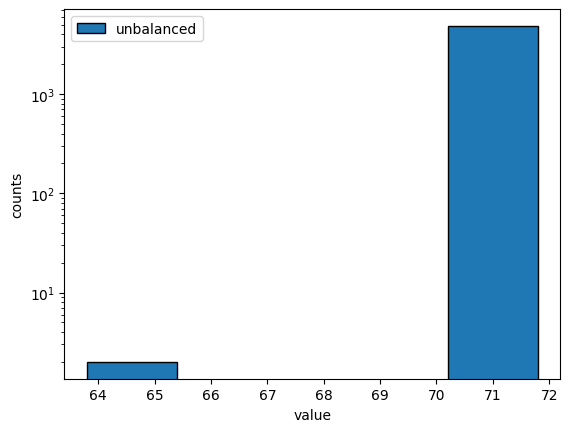

In [22]:
fig, ax = plt.subplots()
bins = {"unbalanced": 5}
for method in ["unbalanced"]:
    ax.hist(
        values[method].keys(),
        weights=values[method].values(),
        bins=bins[method],
        edgecolor="black",
        label=method,
        align="right",
    )
# ax.vlines(-min_cost, 0, 5000, linestyle="--", color="black", label="Optimal", linewidth=2)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("value")
fig.show()